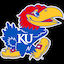

In [1]:
from pathlib import Path
from PIL import Image
import numpy as np
from sympy import Matrix

filename = Path("../img/color/Jayhawk_64x64x3.jpg")

with Image.open(filename, "r") as im:
    display(im)

# True for noisy execution, False for noiseless execution
noisy_execution = False
draw_qc = True

In [2]:
def display_quantum_circuit(qc):
    if draw_qc:
        display(qc.draw('mpl', reverse_bits=True))
        
def display_matrix(matrix):
    try:
        Matrix(matrix)
    except:
        print(matrix)

In [3]:
from qcc.filters import *

stride = 1
# fltr_raw = avg_filter(3, dim = 2)
# fltr_raw = sobel_filter(3, axis=0)
fltr_raw = laplacian_approx(3)
# fltr_raw = gaussian_blur(3)

npad = tuple((0, 2 ** int(np.ceil(np.log2(N))) - N) for N in fltr_raw.shape)
fltr = np.pad(fltr_raw, pad_width=npad, mode="constant", constant_values=0)

display_matrix(fltr)

In [4]:
from qcc.quantum import flatten_image, normalize, to_qubits
from qcc.filters import update_dims

psi, *dims = flatten_image(filename, pad=True)
psi, mag = normalize(psi, include_magnitude=True)

dims_q = [to_qubits(x) for x in dims]
dims_out = update_dims(dims, fltr_raw.shape, stride=stride)

num_qubits = sum(dims_q)
num_states = 2**num_qubits

print(dims_out, mag)

(62, 62, 3) 14051.205784558135


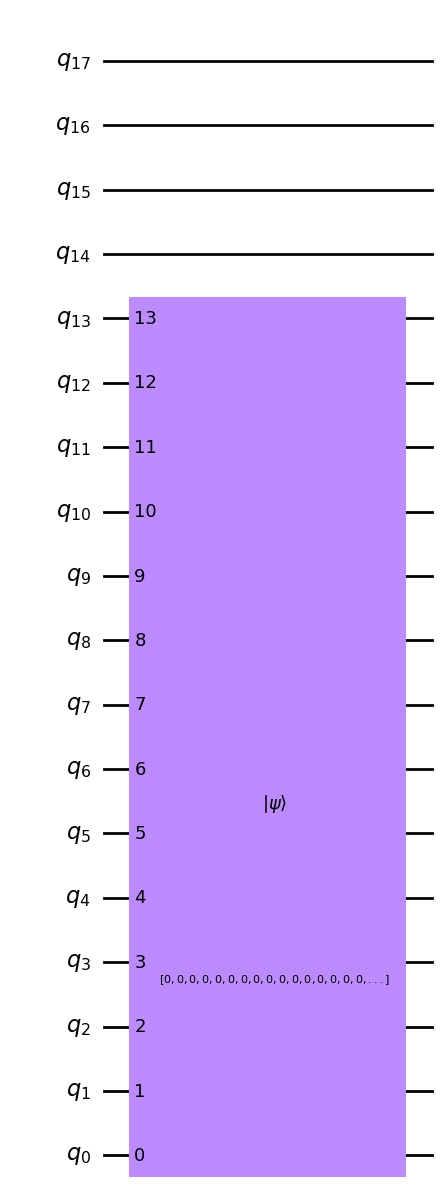

In [5]:
from qiskit import QuantumCircuit
from qiskit.quantum_info.operators import Operator

fltr_shape_q = [int(np.ceil(np.log2(filter_size))) for filter_size in fltr.shape]
num_ancilla = sum(fltr_shape_q)
total_qubits = num_qubits + num_ancilla

qc = QuantumCircuit(total_qubits)
qc.initialize(psi, qc.qubits[:-num_ancilla])

display_quantum_circuit(qc)

In [6]:
# TODO: optimize
def shift(qc: QuantumCircuit, k: int = 1, targets=None, control=None):
    if k == 0:
        return
    if targets is None:
        targets = qc.qubitsz
    
    # Increment / Decrement for 
    for _ in range(abs(k)):
        for i in range(len(targets))[::-np.sign(k)]:
            controls = list(targets[:i])
            
            if control is not None:
                controls += [control]
            
            if len(controls) == 0:
                qc.x(targets[i])
            else:
                qc.mcx(controls, targets[i])

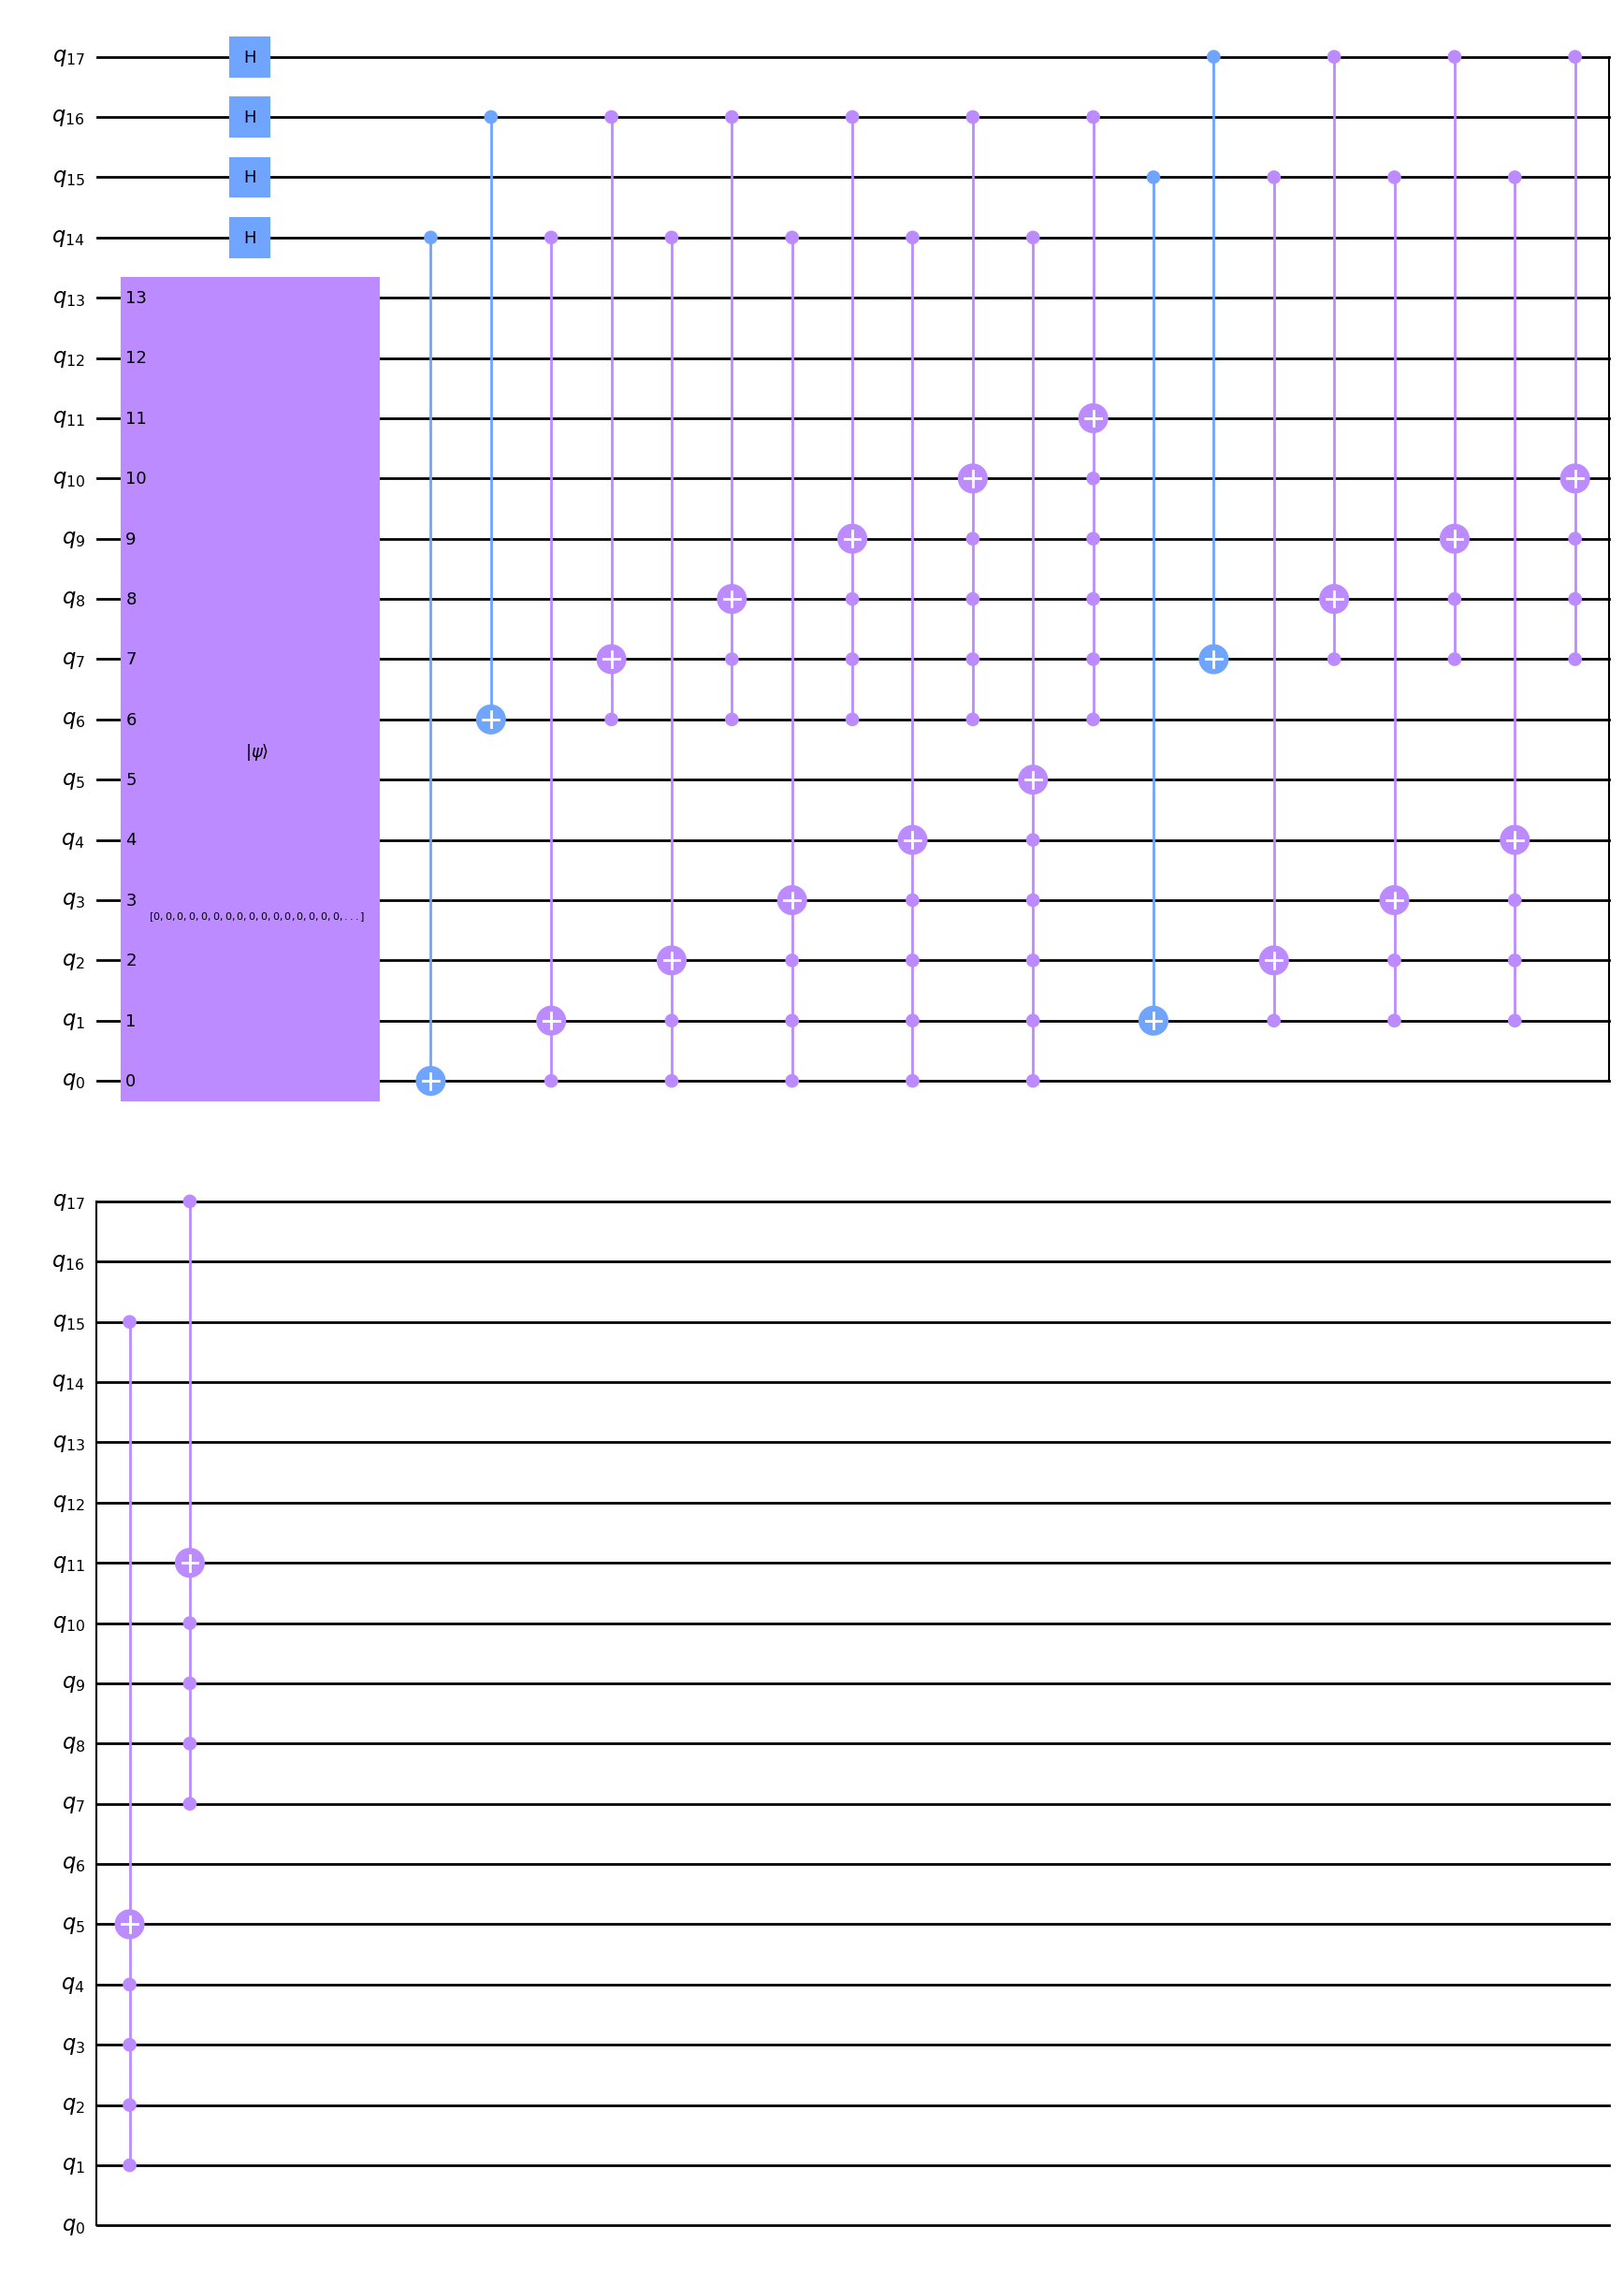

In [7]:
for i, (dim, fq) in enumerate(zip(dims_q[:fltr.ndim], fltr_shape_q)):
    filter_qubits = num_qubits + sum(fltr_shape_q[:i]) + np.arange(fq)
    qc.h(filter_qubits)

    # Shift operation
    qubits = list(sum(dims_q[:i]) + np.arange(dim))
    for i, control_qubit in enumerate(filter_qubits):
        shift(qc, -stride, targets=qubits[i:], control=control_qubit)

display_quantum_circuit(qc)

In [8]:
params, fltr_mag = normalize(fltr.flatten(order="F"), include_magnitude=True)

print(fltr_mag)

display_matrix(params)

1.414213562373095


In [9]:
import numpy as np
from qiskit import QuantumCircuit


def get_params(x_in):
    p = x_in
    while len(p) > 1:
        x = np.reshape(p, (int(len(p) / 2), 2))
        p = np.linalg.norm(x, axis=1)

        with np.errstate(divide="ignore", invalid="ignore"):
            alpha, beta = np.array([y / m if m > 0 else (1, 0) for y, m in zip(x, p)]).T

            alpha_mag, beta_mag = np.abs((alpha, beta))
            alpha_phase, beta_phase = np.angle((alpha, beta))

            with np.errstate(divide="ignore"):
                theta = 2 * np.arctan(beta_mag / alpha_mag)
            phi = beta_phase - alpha_phase
            r = np.sqrt(alpha_mag**2 + beta_mag**2)
            t = beta_phase + alpha_phase

        yield theta, phi, r, t


def c2q(qc: QuantumCircuit, psi_in, targets=None, transpose=False) -> None:
    if targets is None:
        targets = qc.qubits

    theta = []
    phi = []
    t = []

    length = int(2 ** (len(targets) - 1))
    for _theta, _phi, _, _t in get_params(psi_in):
        _theta, _phi, _t = [np.pad(x, (0, length - len(x))) for x in [_theta, _phi, _t]]
        theta.append(_theta)
        phi.append(_phi)
        t.append(_t)
    theta = np.stack(theta, axis=1)
    phi = np.stack(phi, axis=1)
    t = np.stack(t, axis=1)

    if transpose:
        theta = -theta
        phi, t = -t, -phi

    tmp = list(enumerate(targets))
    for j, target in tmp if transpose else reversed(tmp):
        control = [qc.qubits[k] for k in targets[j + 1 :]]

        n_j = len(targets) - 1 - j
        i_max = 2 ** (n_j)

        theta_j = theta[:i_max, j]
        t_j = t[:i_max, j]
        phi_j = phi[:i_max, j]

        if t_j.any():
            t_j = -t_j
            qc.ucrz(t_j.tolist(), control, target)

        qc.ucry(theta_j.tolist(), control, target)

        if phi_j.any():
            qc.ucrz(phi_j.tolist(), control, target)

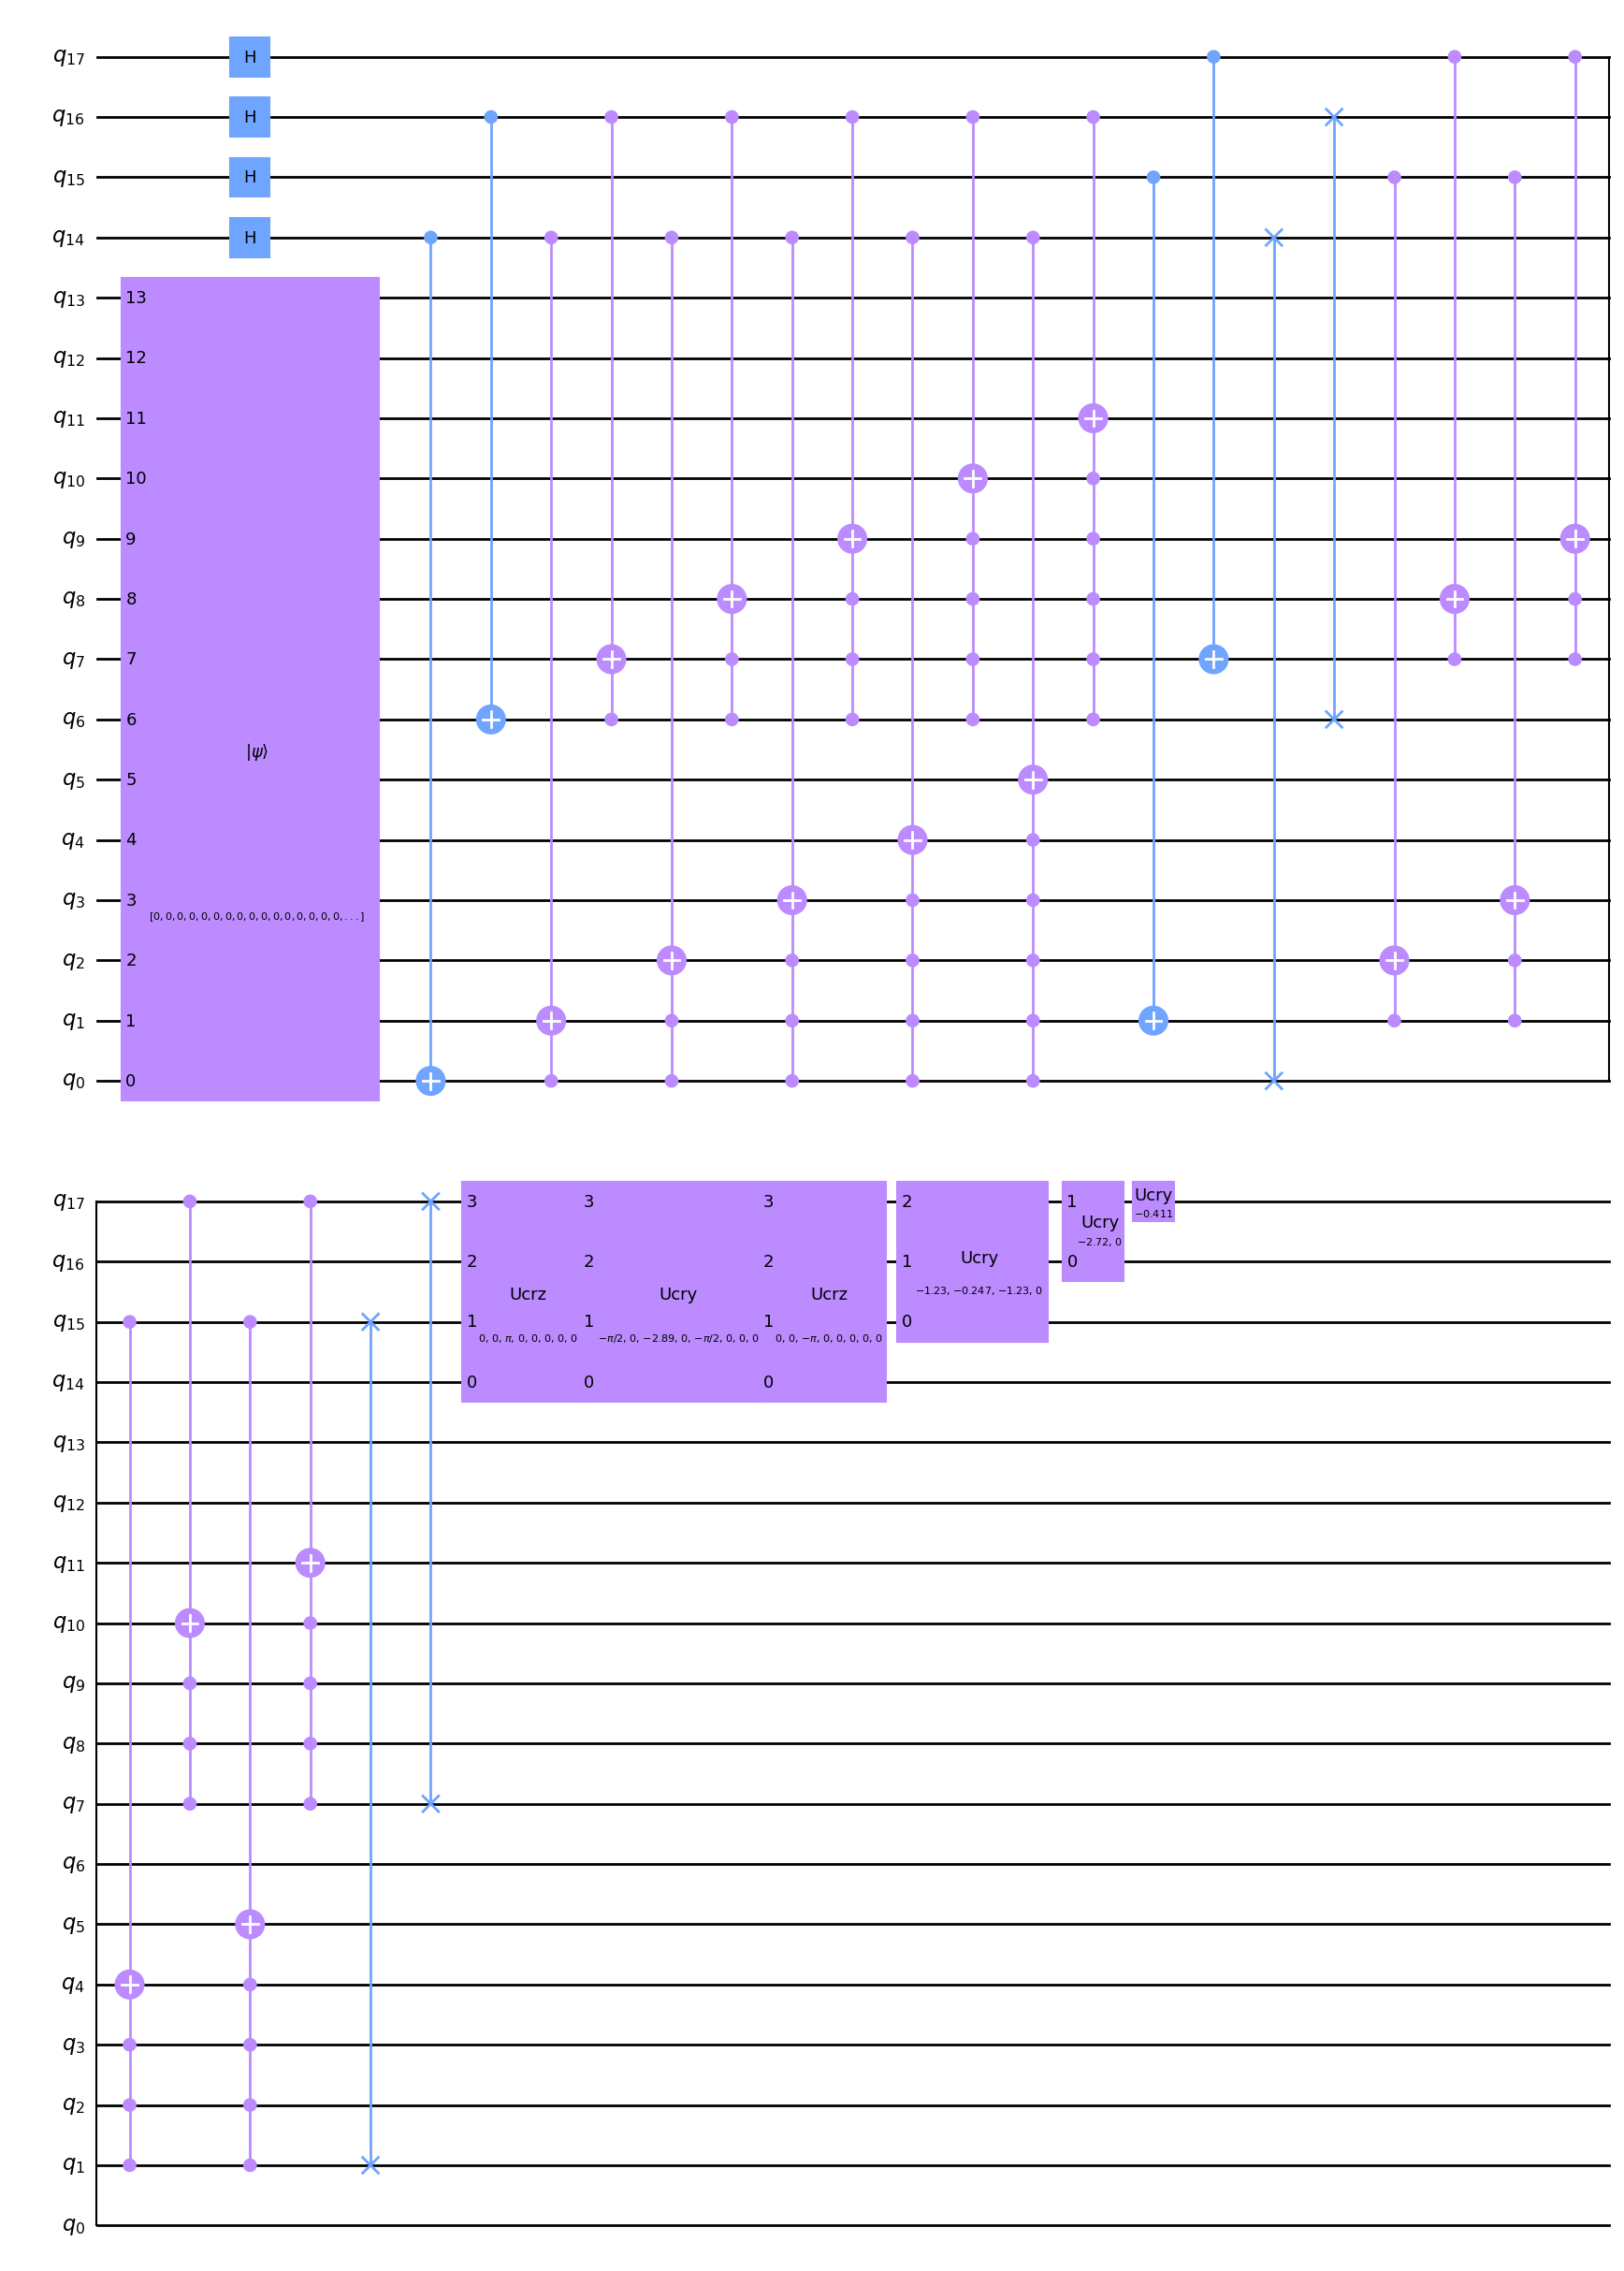

In [10]:
roots = np.concatenate([np.zeros(1, dtype=int), np.cumsum(dims_q[:fltr.ndim-1])]) # base
filter_qubits = np.array([root + np.arange(fq) for root, fq in zip(roots, fltr_shape_q)]).flatten()
   
swap_targets = np.array([num_qubits + sum(fltr_shape_q[:i]) + np.arange(fq) for i, fq in enumerate(fltr_shape_q)]).flatten()
for a,b in zip(filter_qubits, swap_targets):
    qc.swap(a, b)   
 
c2q(qc, params, targets=swap_targets, transpose=True)
    
display_quantum_circuit(qc)

In [11]:
from qiskit import Aer, execute
from qiskit.tools import job_monitor
from qcc.quantum import from_counts

backend = Aer.get_backend('aer_simulator')
shots = backend.configuration().max_shots

if noisy_execution:
    qc.measure_all()
else:
    qc.save_statevector()

job = execute(qc, backend=backend, shots=shots)
job_monitor(job)

result = job.result()

if noisy_execution:
    counts = result.get_counts(qc)
    psi_out = from_counts(counts, shots=shots, num_qubits=total_qubits)
else:
    psi_out = result.get_statevector(qc).data

Job Status: job has successfully run


0.0 286.58948993987894


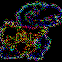

In [12]:
from qcc.quantum import reconstruct

i = 0
img = psi_out.data[i*num_states:(i+1)*num_states]
norm = mag * fltr_mag * np.sqrt(2**num_ancilla)

print(min(np.abs(norm*img)), max(np.abs(norm*img)))

img = reconstruct(norm*img, dims, dims_out)
img = Image.fromarray(np.abs(img).astype(np.uint8))
img.save("output.png")

display(img)

### Classical Results

In [13]:
display_matrix(fltr_raw)

(62, 62, 3) 0.0 250.33333333333331


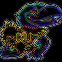

In [14]:
with Image.open(filename, "r") as im:
    image_data = np.asarray(im, dtype=float)

classical_img = convolution(image_data, fltr_raw, stride=stride)

print(classical_img.shape, min(classical_img.flatten()), max(classical_img.flatten()))

classical_img = classical_img.astype(np.uint8)
classical_img = Image.fromarray(classical_img)
display(classical_img)
classical_img.save("output_classical.png")

In [15]:
from qcc.quantum import get_fidelity

fid = get_fidelity(np.asarray(classical_img).flatten(), np.asarray(img).flatten())

print(f"Fidelity: {fid:.03%}")

Fidelity: 68.520%
